In [1]:
import os
import numpy as np
import rasterio as rio
from config import *
from data_acquisition import *
from richdem import TerrainAttribute, LoadGDAL
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
# --- Rutas
ndvi_path = "outputs/output_s2_2024-05-10_2024-05-12.tif"        # Sentinel-2 NDVI (alta resolución)
dem_path = "/home/tidop/Downloads/AP_07598_FBD_F0800_RT1/AP_07598_FBD_F0800_RT1.dem.tif"         # Elevación ALOS PALSAR 12.5m
lst_path = "outputs/output_s3_2024-05-04_2024-05-06.tif"         # LST Sentinel-3 rasterizado (baja resolución)
dem_clip_path = "outputs/output_dem_clip.tif"

# --- Clipping DEM
get_dem(os.path.join(GEOJSON_DIR, "networks.geojson"), dem_path, dem_clip_path, row=2)

In [7]:
# --- Leer DEM
dem_array = rio.open(dem_clip_path).read(1)

# --- Derivar atributos topográficos
dem_rd = LoadGDAL(dem_clip_path)

slope = TerrainAttribute(dem_rd, attrib='slope_degrees')
aspect = TerrainAttribute(dem_rd, attrib='aspect')
curvature = TerrainAttribute(dem_rd, attrib='curvature')  # Puede actuar como un proxy de TPI


A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.171006======================= ] (99% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.149819======================= ] (99% - 0.0s - 1 threads)

A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.0346044====================== ] (99% - 0.0s - 1 threads)===== ] (98% - 0.0s - 1 threads)


In [8]:
# --- Leer NDVI y LST
ndvi_10m = rio.open(ndvi_path).read(1)
lst = rio.open(lst_path).read(1)

# --- Reducción a 100m
target_shape = (dem_array.shape[0] // 10, dem_array.shape[1] // 10)

ndvi_100m = resize(ndvi_10m, target_shape, order=1)
dem_100m = resize(dem_array, target_shape, order=1)
slope_100m = resize(slope, target_shape, order=1)
aspect_100m = resize(aspect, target_shape, order=1)
curvature_100m = resize(curvature, target_shape, order=1)
lst_upsampled_100m = resize(lst, target_shape, order=1)

In [9]:
# --- Stack de variables
X = np.stack([
    ndvi_100m.flatten(),
    dem_100m.flatten(),
    slope_100m.flatten(),
    aspect_100m.flatten(),
    curvature_100m.flatten(),
], axis=1)
y = lst_upsampled_100m.flatten()

# --- Máscara de limpieza
mask = ~np.isnan(y) & np.isfinite(y) & np.isfinite(X).all(axis=1)
X_clean = X[mask]
y_clean = y[mask]

# --- Submuestreo
max_samples = 1_000_000
if len(X_clean) > max_samples:
    X_clean, y_clean = shuffle(X_clean, y_clean, random_state=42)
    X_clean = X_clean[:max_samples]
    y_clean = y_clean[:max_samples]

In [10]:
# --- Entrenamiento
model = RandomForestRegressor(n_estimators=50, max_depth=25, n_jobs=-1)
model.fit(X_clean, y_clean)

# --- Predicción
y_pred = model.predict(X_clean)

# --- Reconstrucción del raster
lst_100m = np.full(target_shape, np.nan)
lst_100m.flat[mask] = y_pred

# --- Métricas
print("R²:", r2_score(y_clean, y_pred))
print("RMSE:", mean_squared_error(y_clean, y_pred, squared=False))

R²: 0.8503597922651893
RMSE: 1.9482343982567567


/home/tidop/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


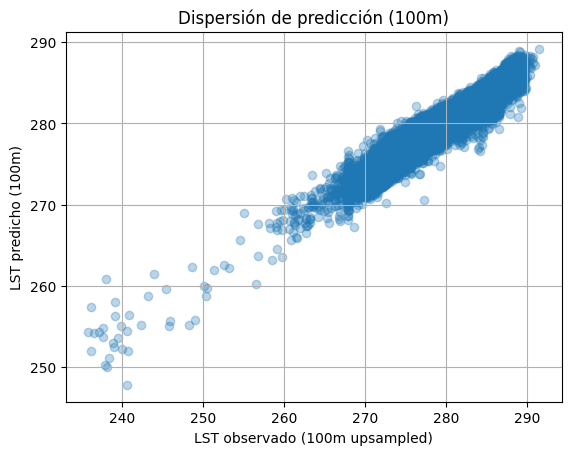

In [11]:
# --- Visualización
plt.scatter(y_clean[:30000], y_pred[:30000], alpha=0.3)
plt.xlabel("LST observado (100m upsampled)")
plt.ylabel("LST predicho (100m)")
plt.title("Dispersión de predicción (100m)")
plt.grid()
plt.show()

## TsHARP

In [12]:
from sklearn.linear_model import LinearRegression

# 1. Reescalar NDVI a resolución de LST
ndvi_coarse = resize(ndvi_10m, lst.shape, order=1)

# 2. Máscara para eliminar valores no válidos
mask_reg = np.isfinite(ndvi_coarse) & np.isfinite(lst)

# 3. Ajustar regresión lineal LST ~ NDVI
reg = LinearRegression()
reg.fit(ndvi_coarse[mask_reg].reshape(-1, 1), lst[mask_reg].reshape(-1, 1))

a = reg.intercept_[0]
b = reg.coef_[0][0]

print(f"Modelo LST = {a:.2f} + {b:.2f} × NDVI")

# 4. Reescalar NDVI a 100 m
ndvi_100m = resize(ndvi_10m, target_shape, order=1)

# 5. Aplicar TsHARP
lst_100m_tsharp = a + b * ndvi_100m

Modelo LST = 280.89 + -0.00 × NDVI


In [18]:
lst_100m.shape, mask.shape

((201, 186), (37386,))

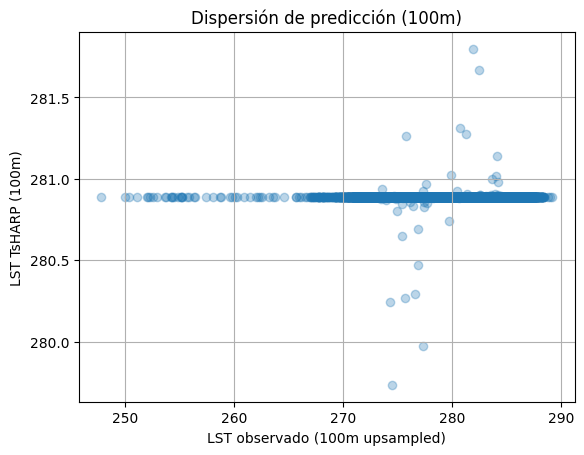

In [ ]:
plt.scatter(lst_100m.flatten()[mask], lst_100m_tsharp.flatten()[mask], alpha=0.3)
plt.xlabel("LST observado (100m upsampled)")
plt.ylabel("LST TsHARP (100m)")
plt.title("Dispersión de predicción (100m)")
plt.grid()
plt.show()

## TsHARP multivariante

In [22]:
dem_coarse = resize(dem_array, lst.shape, order=1)

X_reg = np.stack([ndvi_coarse.flatten(), dem_coarse.flatten()], axis=1)
y_reg = lst.flatten()

mask = np.all(np.isfinite(X_reg), axis=1) & np.isfinite(y_reg)

reg = LinearRegression()
reg.fit(X_reg[mask], y_reg[mask])

LinearRegression()

In [ ]:
mask = ~np.isnan(lst_100m_tsharp) & np.isfinite(lst_100m_tsharp)

# Aplicar a NDVI y DEM en alta resolución
X_highres = np.stack([ndvi_100m.flatten(), dem_100m.flatten()], axis=1)

lst_100m_tsharp_multi = reg.predict(X_highres).reshape(ndvi_100m.shape)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values